In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from fsd_path_planning.demo.streamlit_demo.common import get_cones_for_configuration
import numpy as np
import matplotlib.pyplot as plt
from fsd_path_planning.utils.math_utils import rotate, angle_from_2d_vector
from numpy import array, float64

In [60]:
# position, direction, cones = get_cones_for_configuration("Hairpin Extreme", do_shuffle=True)

# position = np.array([36, 30.0])
# direction = np.array([1, 1.0])
# direction = direction / np.linalg.norm(direction)

from pathlib import Path
position, direction, cones = eval(Path('/home/papalotis/repos/fsd-path-planning/test.txt').read_text())

cones = [np.array(cone).reshape(-1,2) for cone in cones]

In [61]:
cones_together = np.row_stack(cones)

idxs = np.random.default_rng(0).random(len(cones_together)).argsort()


cones_together = cones_together[idxs]

(-4.69808044, 51.88316956, 1.340625, 36.471875)

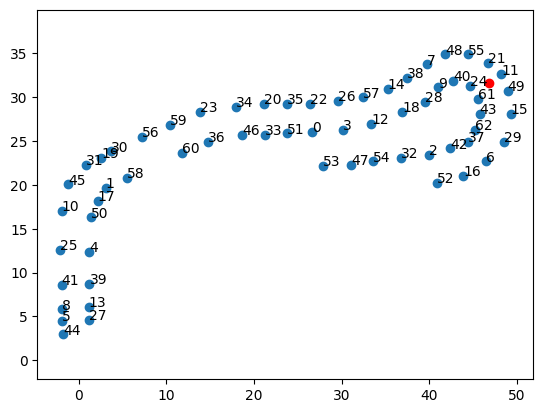

In [62]:

mask_keep = np.ones(len(cones_together), dtype=bool)
# mask_keep[1] = False

cones_together = cones_together[mask_keep]
plt.plot(*cones_together.T, "o")
plt.plot(*position, "ro")
for i, (x,y) in enumerate(cones_together):
    plt.text(x, y, str(i))

plt.axis("equal")

In [63]:
from fsd_path_planning.sorting_cones.trace_sorter.core_trace_sorter import TraceSorter
from fsd_path_planning.utils.cone_types import ConeTypes

In [64]:
ts_kwargs = dict(
    max_n_neighbors=5, max_dist=5.0, max_dist_to_first=6.0, max_length=10, threshold_directional_angle=np.deg2rad(40), threshold_absolute_angle=np.deg2rad(55)
)

ts = TraceSorter(**ts_kwargs)

In [65]:
print(ts.select_first_two_starting_cones(position, direction, cones_together, ConeTypes.RIGHT))
print(ts.select_first_two_starting_cones(position, direction, cones_together, ConeTypes.LEFT))

[24 61]
[11 49]


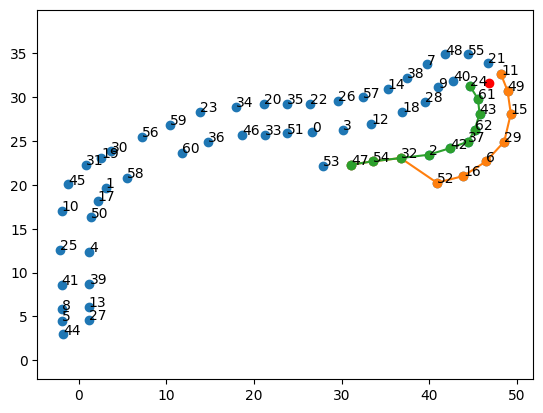

In [74]:
out_left = ts.sort(cones_together, ConeTypes.LEFT, position, direction)
out_right = ts.sort(cones_together, ConeTypes.RIGHT, position, direction)
if out_left is not None:
    left_best_score, left_best_config = out_left[0][0], out_left[1][0]
else:
    left_best_score, left_best_config = [],np.zeros(len(cones_together), dtype=int) - 1

if out_right is not None:
    right_best_score, right_best_config = out_right[0][0], out_right[1][0]
else:
    right_best_score, right_best_config = [], np.zeros(len(cones_together), dtype=int) - 1

left_best_config = left_best_config[left_best_config != -1]
right_best_config = right_best_config[right_best_config != -1]

plt.plot(*cones_together.T, "o")
plt.plot(*position, "ro")

plt.plot(*cones_together[left_best_config].T, "o-")
plt.plot(*cones_together[right_best_config].T, "o-")
plt.axis("equal")

for i, (x,y) in enumerate(cones_together):
    plt.text(x, y, str(i))


In [67]:
from typing import Optional

from itertools import product
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations

from fsd_path_planning.sorting_cones.trace_sorter.line_segment_intersection import pairwise_segment_intersection, number_of_intersections, lines_segments_intersect_indicator


def n_intersections(trace_left, trace_right):
    if len(trace_left) == 1 or len(trace_right) == 1:
        n = 0
    else:
        starts = np.row_stack([trace_left[:-1], trace_right[:-1]])
        ends = np.row_stack([trace_left[1:], trace_right[1:]])

        n_intersections_ignore = len(trace_left) - 2 + len(trace_right) - 2
        raw_intersections = pairwise_segment_intersection(starts, ends)

        n = number_of_intersections(raw_intersections) - n_intersections_ignore
    return n



def find_first_intersection_in_trace(trace: np.ndarray, other_trace: np.ndarray) -> Optional[int]:
    for i in range(len(trace) - 1):
        for j in range(len(other_trace) - 1):
            start_1 = trace[i]
            end_1 = trace[i + 1]
            start_2 = other_trace[j]
            end_2 = other_trace[j + 1]

            if lines_segments_intersect_indicator(start_1, end_1, start_2, end_2):
                return i
        
    return None

95.33239982546182 57.89081013743913
left_config [11 49 15 29  6 16 52 32 54 47]
right_config [24 61 43 62 37 42  2 32 54 47]
same_cone_intersection [32 47 54]
left_intersection_idxs [7 9 8]
right_intersection_idxs [7 9 8]
cone_intersection
new_n_left 7
new_n_right 7
score 148.2878665008784

95.33239982546182 60.97805102229513
left_config [11 49 15 29  6 16 52 32 54 47]
right_config [24 61 43 37 42  2 32 54 47 53]
same_cone_intersection [32 47 54]
left_intersection_idxs [7 9 8]
right_intersection_idxs [6 8 7]
cone_intersection
new_n_left 7
new_n_right 6
score 155.3470074137299

95.33239982546182 61.05916311987815
left_config [11 49 15 29  6 16 52 32 54 47]
right_config [24 61 43 62 42  2 32 54 47 53]
same_cone_intersection [32 47 54]
left_intersection_idxs [7 9 8]
right_intersection_idxs [6 8 7]
cone_intersection
new_n_left 7
new_n_right 6
score 155.4281195113129

95.33239982546182 61.24812484617985
left_config [11 49 15 29  6 16 52 32 54 47]
right_config [24 61 62 37 42  2 32 54 47 53]

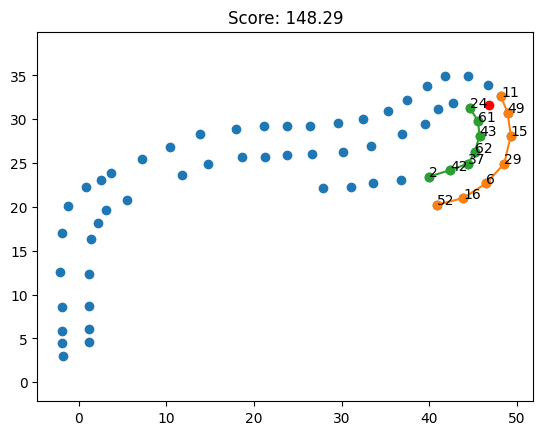

In [73]:
from itertools import chain

def colorless_sort(cones: np.ndarray, position: np.ndarray, direction: np.ndarray):
    # old_print = print
    # print = lambda *args, **kwargs: None

    all_left = ts.sort(cones, ConeTypes.LEFT, position, direction)
    all_right = ts.sort(cones, ConeTypes.RIGHT, position, direction)

    n_none = sum(x is None for x in [all_left, all_right])

    if n_none == 1:
        side_not_none = ConeTypes.LEFT if all_left is not None else ConeTypes.RIGHT
        non_none_result = all_left if all_left is not None else all_right
        _, configs = non_none_result
        best_config = configs[0]
        best_config = best_config[best_config != -1]
        best_trace = cones[best_config]

        if side_not_none == ConeTypes.LEFT:
            return best_trace, np.zeros((0, 2)), -1
        else:
            return np.zeros((0,2)), best_trace, -1
        
    
    if n_none == 2:
        return np.zeros((0,2)), np.zeros((0,2)), -1


    left_scores, left_configs = all_left
    right_scores, right_configs = all_right

    left_zip = zip(left_scores, left_configs)
    right_zip = zip(right_scores, right_configs)

    it = list(product(left_zip, right_zip))
    scores = []
    configs = []

    for i,x in enumerate(it):
        (left_score, left_config), (right_score, right_config) = x

        print(left_score, right_score)

        left_config = left_config[left_config != -1]
        right_config = right_config[right_config != -1]

        orig_left_config = left_config.copy()
        orig_right_config = right_config.copy()
        
        print("left_config", left_config)
        print("right_config", right_config)

        same_cone_intersection, left_intersection_idxs, right_intersection_idxs = np.intersect1d(left_config, right_config, return_indices=True)
        print("same_cone_intersection", same_cone_intersection)
        print("left_intersection_idxs", left_intersection_idxs)
        print("right_intersection_idxs", right_intersection_idxs)
        if len(same_cone_intersection) > 0 and len(left_config) >= 3 and len(right_config) >= 3:
            print('cone_intersection')
            left_stop_idx = min(left_intersection_idxs)
            right_stop_idx = min(right_intersection_idxs)

            if left_stop_idx == len(left_config) - 1:
                new_right_stop_idx = len(right_config)
            else:
                new_right_stop_idx = right_stop_idx

            if right_stop_idx == len(right_config) - 1:
                new_left_stop_idx = len(left_config)
            else:
                new_left_stop_idx = left_stop_idx

            left_config = left_config[:new_left_stop_idx]
            right_config = right_config[:new_right_stop_idx]

            new_n_left = len(left_config)
            new_n_right = len(right_config)
            print("new_n_left", new_n_left)
            print("new_n_right", new_n_right)
            if new_n_left < 3 and new_n_right < 3:
                left_score = float("inf")
                right_score = float("inf")
            elif new_n_left < 3:
                right_score = cost_configurations(cones, right_config[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]
                left_score = right_score
            elif new_n_right < 3:
                left_score = cost_configurations(cones, left_config[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
                right_score = left_score
            else:
                left_score = cost_configurations(cones, left_config[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
                right_score = cost_configurations(cones, right_config[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]


        left_trace = cones[left_config]
        right_trace = cones[right_config]

        edges_intersections = n_intersections(left_trace, right_trace)

        if edges_intersections > 0:
            print('edges_intersection')
            stop_left = find_first_intersection_in_trace(left_trace, right_trace)
            stop_right = find_first_intersection_in_trace(right_trace, left_trace)

            left_config = left_config[:stop_left]
            right_config = right_config[:stop_right]

            if len(left_config) > 2 and len(right_config) > 2:
                left_score = cost_configurations(cones, left_config[None], ConeTypes.LEFT, position, direction, return_individual_costs=False)[0]
                right_score = cost_configurations(cones, right_config[None], ConeTypes.RIGHT, position, direction, return_individual_costs=False)[0]
            else:
                left_score = float("inf")
                right_score = float("inf")
            
        

        score = left_score + right_score

        print('score', score)
        print()
        scores.append(score)
        configs.append((left_config, right_config))

        if i == 0 and len(left_config) == len(orig_left_config) and np.allclose(orig_left_config, left_config) and len(right_config) == len(orig_right_config) and np.allclose(orig_right_config, right_config):
            print('first solution seems good', score)
            break

    if len(scores) == 0:
        return None, None, None
    

    best_score_idx = np.argmin(scores)
    best_score = scores[best_score_idx]
    best_combination = configs[best_score_idx]

    best_left, best_right = best_combination
    best_left_points = cones[best_left[best_left != -1]]
    best_right_points = cones[best_right[best_right != -1]]

    return best_left_points, best_right_points, best_score


left, right, score = colorless_sort(cones_together, position, direction)

if left is not None:
    plt.plot(*cones_together.T, "o")
    plt.plot(*position, "ro")
    plt.plot(*left.T, "o-")
    plt.plot(*right.T, "o-")
    plt.title(f"Score: {score:.2f}")
    plt.axis("equal")
    for c in chain(left, right):
        idx = np.linalg.norm(c - cones_together, axis=1).argmin()
        plt.text(*c, idx)
else:
    print("No solution found")

In [69]:
from fsd_path_planning.demo.json_demo import load_data_json
from tqdm import tqdm

demo_positions, demo_directions, demo_cones = load_data_json(Path('/home/papalotis/repos/fsd-path-planning/fsd_path_planning/demo/fss_19_4_laps.json'))
# demo_positions, demo_directions, demo_cones = load_data_json()

it = list(enumerate(zip(demo_positions, demo_directions, demo_cones)))


# for i, (demo_positions_i, demo_directions_i, demo_cones_i) in tqdm(it[:800]):

#     demo_cones_i = [np.array(cones_of_type).reshape(-1,2) for cones_of_type in demo_cones_i]
#     cones_together_i = np.row_stack(demo_cones_i)
#     try:
#         result = colorless_sort(cones_together_i, demo_positions_i, demo_directions_i)
#     except:
#         print(i)
#         raise
#     # print(result)
#     if any(x is None for x in result):
#         result = last_result

#     left_cones, right_cones, score = result

#     plt.plot(*cones_together_i.T, "o")
#     plt.plot(*demo_positions_i, "ro")
#     if score is not None:
#         if left_cones is not None and score < float("inf"):
#             plt.plot(*left_cones[:-1].T, "o-", label="left")

#         if right_cones is not None and score < float("inf"):
#             plt.plot(*right_cones[:-1].T, "o-", label="right")

#     plt.axis("equal")
#     plt.title(f"{i}")
#     plt.savefig(f"frames/frame_{i:04d}.png")
#     plt.close()

#     last_result = result
#     # plt.show()

In [59]:
x=str(repr(it[186][1]))
Path("test.txt").write_text(x)

2335